# Importing Dependencies

In [ ]:
%%capture
!pip install yfinance
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set
from matplotlib.ticker import FuncFormatter
from collections import namedtuple
%matplotlib inline
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import numba as nb
#import numpy_ext as npx
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# AIFS Sales Projection 

## Revenue

In [ ]:
def calc_revenue(upper, skew, nsim, price):
  import numpy as np
  from scipy.stats import skewnorm
  import matplotlib.pyplot as plt


  numValues = nsim
  maxValue = upper
  skewness = skew #Negative values are left skewed, positive values are right skewed.

  random = skewnorm.rvs(a = skewness ,loc=maxValue, size=numValues)  #Skewnorm function
  print(random)
  print(min(random))
  random = random - min(random)      #Shift the set so the minimum value is equal to zero.
  random = random / max(random)      #Standadize all the vlues between 0 and 1. 
  random = random * maxValue         #Multiply the standardized values by the maximum value.

  #Plot histogram to check skewness
  plt.hist(random,75,density=True, color = 'green', alpha=0.3)
  plt.xlabel("Sales Volume")
  plt.ylabel("Probability")

  plt.show()

  print(np.sum(np.where(random < 10000, 1, 0)))

  return random

[35000.09415831 34998.94442697 34999.72816214 ... 34999.82399345
 34999.88134836 34999.71449395]
34996.41119054566


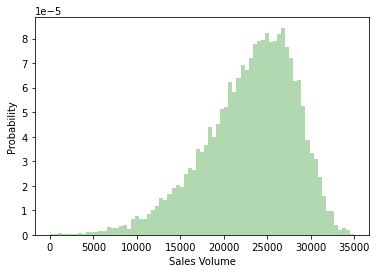

176
500


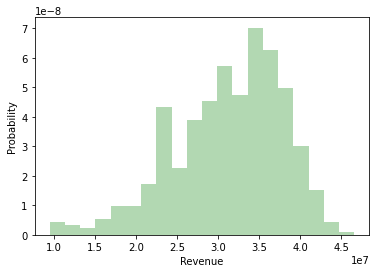

In [ ]:
sales_vol = calc_revenue(35000,-3.7, 10000, 5200)
import random
sales_vol.sort()
sale = random.sample(sales_vol.tolist(), 500)
sale = pd.Series(sale)
print(len(sale))
revenue = sale * 1350
plt.hist(revenue,20,density=True, color = 'green', alpha=0.3)
plt.xlabel("Revenue")
plt.ylabel("Probability")
plt.show()
df = pd.DataFrame(list(zip(sale, revenue)))
df.columns = ['Volume', 'Revenue']

# Heston Model For Exchnage Rate Simulaiton

In [ ]:
#Installing Dependencies
%%capture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install py_vollib_vectorized
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [ ]:
S0 = 1.22 # asset price
T = 1.0 # time in years
r = 0.03 # risk-free rate
N = 252 # number of time steps in simulation
M = 5000 # number of simulations
# Heston dependent parameters
kappa = 6 # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.087**2 # long-term mean of variance under risk-neutral dynamics
v0 = 0.099**2 # initial variance under risk-neutral dynamics
rho = 0.4 # correlation between returns and variances under risk-neutral dynamics
sigma = 0.099 # volatility of volatility
theta, v0

(0.007568999999999999, 0.009801)

In [ ]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
  """
  Inputs:
  - S0, v0: initial parameters for asset and variance
  - rho : correlation between asset returns and variance
  - kappa : rate of mean reversion in variance process
  - theta : long-term mean of variance process
  - sigma : vol of vol / volatility of variance process
  - T : time of simulation
  - N : number of time steps
  - M : number of scenarios / simulations
  Outputs:
  - asset prices over time (numpy array)
  - variance over time (numpy array)
  """
  # initialise other parameters
  dt = T/N
  mu = np.array([0,0])
  cov = np.array([[1,rho],
  [rho,1]])
  # arrays for storing prices and variances
  S = np.full(shape=(N+1,M), fill_value=S0)
  v = np.full(shape=(N+1,M), fill_value=v0)
  # sampling correlated brownian motions under risk-neutral measure
  Z = np.random.multivariate_normal(mu, cov, (N,M))
  for i in range(1,N+1):
    S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
    v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
  return S, v

In [ ]:
rho_p = 0.436
rho_n = -0.436
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

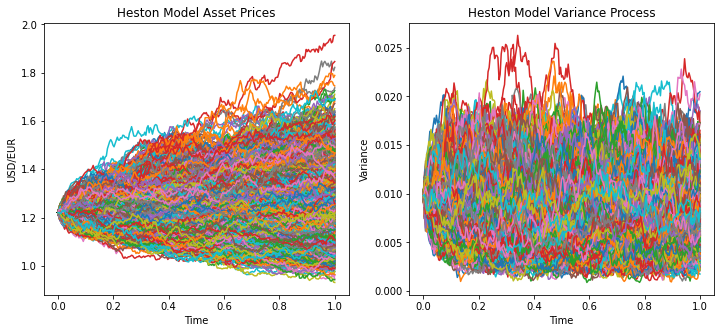

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('USD/EUR')
ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

In [ ]:
import pandas as pd
usdeur = pd.DataFrame(S_p)

In [ ]:
y1_prices = usdeur.iloc[251]
y1_mean = y1_prices.mean()
fx = pd.DataFrame(y1_prices)
fx.columns = ['fx_1']
fx['delta'] = 1.22 - fx['fx_1'] 
fx.head()

,fx_1,delta
0,1.196769,0.023231
1,1.255724,-0.035724
2,1.271338,-0.051338
3,1.223767,-0.003767
4,1.164585,0.055415


In [ ]:
fx_cdf = ECDF(y1_prices)

In [ ]:
fx_cdf(1.247 * 1.05)

0.7056

# Data Preparing for Profit Simulaiton

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot

In [ ]:
fx.head()

,fx_1,delta
0,1.196769,0.023231
1,1.255724,-0.035724
2,1.271338,-0.051338
3,1.223767,-0.003767
4,1.164585,0.055415


In [ ]:
# 0% Hedging and Option %
df['0%_0%_vol'] = df['Volume'] 
df['0%_25%_vol'] = df['Volume'] 
df['0%_50%_vol'] = df['Volume'] 
df['0%_75%_vol'] = df['Volume'] 
df['0%_100%_vol'] = df['Volume'] 
# Option Expense 
df['0%_0%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['0%_25%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['0%_50%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['0%_75%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['0%_100%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000


# 25% Hedging and Option %
df['25%_0%_vol'] = df['Volume'] * 0.75
df['25%_25%_vol'] = df['Volume'] * 0.8125
df['25%_50%_vol'] = df['Volume'] * 0.8750
df['25%_75%_vol'] = df['Volume'] * 0.75
df['25%_100%_vol'] = df['Volume'] 
# Option Expense 
df['25%_0%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['25%_25%_opt_cost'] = df['Volume'] * 0.003125 * 1.22 * 1000
df['25%_50%_opt_cost'] = df['Volume'] * 0.00625 * 1.22 * 1000
df['25%_75%_opt_cost'] = df['Volume'] * 0.009375 * 1.22 * 1000
df['25%_100%_opt_cost'] = df['Volume'] * 0.0125 * 1.22 * 1000

# 50% Hedging and Option %
df['50%_0%_vol'] = df['Volume'] * 0.50
df['50%_25%_vol'] = df['Volume'] * 0.625
df['50%_50%_vol'] = df['Volume'] * 0.75
df['50%_75%_vol'] = df['Volume'] * 0.875
df['50%_100%_vol'] = df['Volume'] 
# Option Cost
df['50%_0%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['50%_25%_opt_cost'] = df['Volume'] * 0.00625 * 1.22 * 1000
df['50%_50%_opt_cost'] = df['Volume'] * 0.0125 * 1.22 * 1000
df['50%_75%_opt_cost'] = df['Volume'] * 0.01875 * 1.22 * 1000
df['50%_100%_opt_cost'] = df['Volume'] *0.025 * 1.22 * 1000


# 75% Hedging and Option %
df['75%_0%_vol'] = df['Volume'] * 0.25
df['75%_25%_vol'] = df['Volume'] * 0.4375
df['75%_50%_vol'] = df['Volume'] * 0.625
df['75%_75%_vol'] = df['Volume'] * 0.8125
df['75%_100%_vol'] = df['Volume'] 
# Option Cost
df['75%_0%_opt_cost'] = df['Volume'] * 0 * 1.22 * 1000
df['75%_25%_opt_cost'] = df['Volume'] * 0.009375 * 1.22 * 1000
df['75%_50%_opt_cost'] = df['Volume'] * 0.01875 * 1.22 * 1000
df['75%_75%_opt_cost'] = df['Volume'] * 0.028125 * 1.22 * 1000
df['75%_100%_opt_cost'] = df['Volume'] *0.0375 * 1.22 * 1000

# 100% Hedging and Option %
df['100%_0%_vol'] = df['Volume'] * 0.25
df['100%_25%_vol'] = df['Volume'] * 0.25
df['100%_50%_vol'] = df['Volume'] * 0.50
df['100%_75%_vol'] = df['Volume'] * 0.75
df['100%_100%_vol'] = df['Volume'] 
# Option Expense
df['100%_0%_opt_cost'] = df['Volume'] * 0.0 * 1.22 * 1000
df['100%_25%_opt_cost'] = df['Volume'] * 0.0125 * 1.22 * 1000
df['100%_50%_opt_cost'] = df['Volume'] * 0.025 * 1.22 * 1000
df['100%_75%_opt_cost'] = df['Volume'] * 0.0375 * 1.22 * 1000
df['100%_100%_opt_cost'] = df['Volume'] *0.05 * 1.22 * 1000

In [ ]:
##### Experimental ----********-------

df['Initial_Vol'] = [25000] * len(df)
df['Volume_Delta'] = df['Volume'] - df['Initial_Vol']



# 0% Hedging and Option %
df['0%_0%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
df['0%_25%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
df['0%_50%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
df['0%_75%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
df['0%_100%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
# Option Expense 
df['0%_0%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['0%_25%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['0%_50%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['0%_75%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['0%_100%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000


# 25% Hedging and Option %
df['25%_0%_vol'] = df['Initial_Vol'] * 0.75 + df['Volume_Delta']
df['25%_25%_vol'] = df['Initial_Vol'] * 0.8125 + df['Volume_Delta']
df['25%_50%_vol'] = df['Initial_Vol'] * 0.8750 + df['Volume_Delta']
df['25%_75%_vol'] = df['Initial_Vol'] * 0.9375 + df['Volume_Delta']
df['25%_100%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
# Option Expense 
df['25%_0%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['25%_25%_opt_cost'] = df['Initial_Vol'] * 0.003125 * 1.22 * 1000
df['25%_50%_opt_cost'] = df['Initial_Vol'] * 0.00625 * 1.22 * 1000
df['25%_75%_opt_cost'] = df['Initial_Vol'] * 0.009375 * 1.22 * 1000
df['25%_100%_opt_cost'] = df['Initial_Vol'] * 0.0125 * 1.22 * 1000

# 50% Hedging and Option %
df['50%_0%_vol'] = df['Initial_Vol'] * 0.50 + df['Volume_Delta']
df['50%_25%_vol'] = df['Initial_Vol'] * 0.625 + df['Volume_Delta']
df['50%_50%_vol'] = df['Initial_Vol'] * 0.75 + df['Volume_Delta']
df['50%_75%_vol'] = df['Initial_Vol'] * 0.875 + df['Volume_Delta']
df['50%_100%_vol'] = df['Initial_Vol']  + df['Volume_Delta']
# Option Cost
df['50%_0%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['50%_25%_opt_cost'] = df['Initial_Vol'] * 0.00625 * 1.22 * 1000
df['50%_50%_opt_cost'] = df['Initial_Vol'] * 0.0125 * 1.22 * 1000
df['50%_75%_opt_cost'] = df['Initial_Vol'] * 0.01875 * 1.22 * 1000
df['50%_100%_opt_cost'] = df['Initial_Vol'] *0.025 * 1.22 * 1000


# 75% Hedging and Option %
df['75%_0%_vol'] = df['Initial_Vol'] * 0.25 + df['Volume_Delta']
df['75%_25%_vol'] = df['Initial_Vol'] * 0.4375 + df['Volume_Delta']
df['75%_50%_vol'] = df['Initial_Vol'] * 0.625 + df['Volume_Delta']
df['75%_75%_vol'] = df['Initial_Vol'] * 0.8125 + df['Volume_Delta']
df['75%_100%_vol'] = df['Initial_Vol'] + df['Volume_Delta']
# Option Cost
df['75%_0%_opt_cost'] = df['Initial_Vol'] * 0 * 1.22 * 1000
df['75%_25%_opt_cost'] = df['Initial_Vol'] * 0.009375 * 1.22 * 1000
df['75%_50%_opt_cost'] = df['Initial_Vol'] * 0.01875 * 1.22 * 1000
df['75%_75%_opt_cost'] = df['Initial_Vol'] * 0.028125 * 1.22 * 1000
df['75%_100%_opt_cost'] = df['Initial_Vol'] *0.0375 * 1.22 * 1000

# 100% Hedging and Option %
df['100%_0%_vol'] = df['Initial_Vol'] * 0.25 + df['Volume_Delta']
df['100%_25%_vol'] = df['Initial_Vol'] * 0.25 + df['Volume_Delta']
df['100%_50%_vol'] = df['Initial_Vol'] * 0.50 + df['Volume_Delta']
df['100%_75%_vol'] = df['Initial_Vol'] * 0.75 + df['Volume_Delta']
df['100%_100%_vol'] = df['Initial_Vol']  + df['Volume_Delta']
# Option Expense
df['100%_0%_opt_cost'] = df['Initial_Vol'] * 0.0 * 1.22 * 1000
df['100%_25%_opt_cost'] = df['Initial_Vol'] * 0.0125 * 1.22 * 1000
df['100%_50%_opt_cost'] = df['Initial_Vol'] * 0.025 * 1.22 * 1000
df['100%_75%_opt_cost'] = df['Initial_Vol'] * 0.0375 * 1.22 * 1000
df['100%_100%_opt_cost'] = df['Initial_Vol'] *0.05 * 1.22 * 1000

In [ ]:
# Fx over Exposure 
df['futures_exposure_0%_0%_vol'] = df['Initial_Vol']  *0
df['futures_exposure_0%_25%_vol'] = df['Initial_Vol'] * 0
df['futures_exposure_0%_50%_vol'] =  df['Initial_Vol'] * 0
df['futures_exposure_0%_75%_vol']=  df['Initial_Vol'] * 0 
df['futures_exposure_0%_100%_vol'] =  df['Initial_Vol'] * 0 

df['futures_exposure_25%_0%_vol'] = np.where( (df['Initial_Vol'] * 0.25 * 1) > df['Volume'], (df['Initial_Vol'] * 0.25 * 1)- df['Volume'], 0) * 1000
df['futures_exposure_25%_25%_vol'] =np.where( (df['Initial_Vol'] * 0.25 * 0.75) > df['Volume'], (df['Initial_Vol'] * 0.25 * 0.75)- df['Volume'], 0) * 1000
df['futures_exposure_25%_50%_vol'] =np.where( (df['Initial_Vol'] * 0.25 * 0.5) > df['Volume'], (df['Initial_Vol'] * 0.25 * 0.5)- df['Volume'], 0) * 1000
df['futures_exposure_25%_75%_vol'] =np.where( (df['Initial_Vol'] * 0.25 * 0.25) > df['Volume'], (df['Initial_Vol'] * 0.25 * 0.25)- df['Volume'], 0) * 1000
df['futures_exposure_25%_100%_vol'] =np.where( (df['Initial_Vol'] * 0.25 * 0) > df['Volume'], (df['Initial_Vol'] * 0.25 * 0)- df['Volume'], 0) * 1000

df['futures_exposure_50%_0%_vol'] = np.where( (df['Initial_Vol'] * 0.5 * 1) > df['Volume'], (df['Initial_Vol'] * 0.5 * 1)- df['Volume'], 0) * 1000
df['futures_exposure_50%_25%_vol']=np.where( (df['Initial_Vol'] * 0.5 * 0.75) > df['Volume'], (df['Initial_Vol'] * 0.5 * 0.75)- df['Volume'], 0) * 1000
df['futures_exposure_50%_50%_vol'] =np.where( (df['Initial_Vol'] * 0.5 * 0.5) > df['Volume'], (df['Initial_Vol'] * 0.5 * 0.50)- df['Volume'], 0) * 1000
df['futures_exposure_50%_75%_vol'] =np.where( (df['Initial_Vol'] * 0.5 * 0.25) > df['Volume'], (df['Initial_Vol'] * 0.5 * 0.25)- df['Volume'], 0) * 1000
df['futures_exposure_50%_100%_vol'] =np.where( (df['Initial_Vol'] * 0.5 * 0) > df['Volume'], (df['Initial_Vol'] * 0.5 * 0)- df['Volume'], 0) * 1000

df['futures_exposure_75%_0%_vol'] = np.where( (df['Initial_Vol'] * 0.75 * 1) > df['Volume'], (df['Initial_Vol'] * 0.75 * 1)- df['Volume'], 0) * 1000
df['futures_exposure_75%_25%_vol']=np.where( (df['Initial_Vol'] * 0.75 * 0.75) > df['Volume'], (df['Initial_Vol'] * 0.75 * 0.75)- df['Volume'], 0) * 1000
df['futures_exposure_75%_50%_vol'] =np.where( (df['Initial_Vol'] * 0.75 * 0.5) > df['Volume'], (df['Initial_Vol'] * 0.75 * 0.50)- df['Volume'], 0) * 1000
df['futures_exposure_75%_75%_vol'] =np.where( (df['Initial_Vol'] * 0.75 * 0.25) > df['Volume'], (df['Initial_Vol'] * 0.75 * 0.25)- df['Volume'], 0) * 1000
df['futures_exposure_75%_100%_vol'] =np.where( (df['Initial_Vol'] * 0.75 * 0) > df['Volume'], (df['Initial_Vol'] * 0.75 * 0)- df['Volume'], 0) * 1000

df['futures_exposure_100%_0%_vol'] = np.where( (df['Initial_Vol'] * 1 * 1) > df['Volume'], (df['Initial_Vol'] * 1 * 1)- df['Volume'], 0) * 1000
df['futures_exposure_100%_25%_vol']=np.where( (df['Initial_Vol'] * 1 * 0.75) > df['Volume'], (df['Initial_Vol'] * 1 * 0.75)- df['Volume'], 0) * 1000
df['futures_exposure_100%_50%_vol'] =np.where( (df['Initial_Vol'] * 1 * 0.5) > df['Volume'], (df['Initial_Vol'] * 1 * 0.50)- df['Volume'], 0) * 1000
df['futures_exposure_100%_75%_vol'] =np.where( (df['Initial_Vol'] * 1 * 0.25) > df['Volume'], (df['Initial_Vol'] * 1 * 0.25)- df['Volume'], 0) * 1000
df['futures_exposure_100%_100%_vol'] =np.where( (df['Initial_Vol'] * 1 * 0) > df['Volume'], (df['Initial_Vol'] * 1 * 0)- df['Volume'], 0)* 1000 


In [ ]:
np.where(df['futures_exposure_100%_0%_vol']<0)

(array([], dtype=int64),)

In [ ]:
df['0%'] = df['Initial_Vol'] + df['Volume_Delta']
df['25%'] = df['Initial_Vol'] * 0.75 + df['Volume_Delta']
df['50%'] = df['Initial_Vol'] * 0.50 + df['Volume_Delta']
df['75%'] = df['Initial_Vol'] * 0.25 + df['Volume_Delta']
df['100%'] = df['Initial_Vol'] * 0 +  df['Volume_Delta']

# Monte Carlo for Profit Calculation

In [ ]:
# VaR Calculation for 0% [0,0, 0.25, 0.50, 0.75, 1.0]
revenue = []
VaR_0_0 = []
VaR_0_25 = []
VaR_0_50= []
VaR_0_75 = []
VaR_0_100 = []

VaR_25_0 = []
VaR_25_25 = []
VaR_25_50= []
VaR_25_75 = []
VaR_25_100 = []

VaR_50_0 = []
VaR_50_25 = []
VaR_50_50= []
VaR_50_75 = []
VaR_50_100 = []

VaR_75_0 = []
VaR_75_25 = []
VaR_75_50= []
VaR_75_75 = []
VaR_75_100 = []

VaR_100_0 = []
VaR_100_25 = []
VaR_100_50= []
VaR_100_75 = []
VaR_100_100 = []


for index, row in df.iterrows():  
  for exchnage_rate in y1_prices: 
    #Revenue
    revenue.append(row['Volume'] * 1350)
    rate_ratio = 1.22/exchnage_rate
    r = row['Volume'] * 1350
    if exchnage_rate > 1.22 : # If greater than 1.22, the Dollar Weak, and use Hedged Exposure

      # 0% Hedging
      VaR_0_0.append(r - (row['0%']*exchnage_rate*1000) - row['0%_0%_opt_cost'] )
      VaR_0_25.append(r - (row['0%']*exchnage_rate*1000) - row['0%_25%_opt_cost'])
      VaR_0_50.append(r - (row['0%']*exchnage_rate*1000) - row['0%_50%_opt_cost'])
      VaR_0_75.append(r - (row['0%']*exchnage_rate*1000) - row['0%_75%_opt_cost'])
      VaR_0_100.append(r - (row['0%']*exchnage_rate*1000) - row['0%_100%_opt_cost'])
      # 25% Hedging
      VaR_25_0.append(r - (row['25%']*exchnage_rate*1000) - row['25%_0%_opt_cost'] - (row['75%'] *1.22*1000 ) + ( (row['futures_exposure_25%_0%_vol'] * exchnage_rate)-(row['futures_exposure_25%_0%_vol'] * 1.22) ) )
      VaR_25_25.append(r - (row['25%']*exchnage_rate*1000) - row['25%_25%_opt_cost'] - (row['75%'] *1.22*1000 ) + ( (row['futures_exposure_25%_25%_vol'] * exchnage_rate)-(row['futures_exposure_25%_25%_vol'] * 1.22) ) )
      VaR_25_50.append(r - (row['25%']*exchnage_rate*1000) - row['25%_50%_opt_cost'] - (row['75%'] *1.22*1000 ) + ( (row['futures_exposure_25%_50%_vol'] * exchnage_rate)-(row['futures_exposure_25%_50%_vol'] * 1.22) ) )
      VaR_25_75.append(r - (row['25%']*exchnage_rate*1000) - row['25%_75%_opt_cost'] - (row['75%'] *1.22*1000 ) + ( (row['futures_exposure_25%_75%_vol'] * exchnage_rate)-(row['futures_exposure_25%_75%_vol'] * 1.22) ))
      VaR_25_100.append(r - (row['25%']*exchnage_rate*1000) - row['25%_100%_opt_cost'] - (row['75%'] *1.22*1000 )+ ( (row['futures_exposure_25%_100%_vol'] * exchnage_rate)-(row['futures_exposure_25%_100%_vol'] * 1.22) ))
      # 50% Hedging
      VaR_50_0.append(r - (row['50%']*exchnage_rate*1000) - row['50%_0%_opt_cost'] - (row['50%'] *1.22*1000 )+ ( (row['futures_exposure_50%_0%_vol'] * exchnage_rate)-(row['futures_exposure_25%_0%_vol'] * 1.22) ) )
      VaR_50_25.append(r - (row['50%']*exchnage_rate*1000) - row['50%_25%_opt_cost']- (row['50%'] *1.22*1000 )+ ( (row['futures_exposure_50%_25%_vol'] * exchnage_rate)-(row['futures_exposure_25%_25%_vol'] * 1.22) ) )
      VaR_50_50.append(r - (row['50%']*exchnage_rate*1000) - row['50%_50%_opt_cost']- (row['50%'] *1.22*1000 )+ ( (row['futures_exposure_50%_50%_vol'] * exchnage_rate)-(row['futures_exposure_25%_50%_vol'] * 1.22) ) )
      VaR_50_75.append(r - (row['50%']*exchnage_rate*1000) - row['50%_75%_opt_cost']- (row['50%'] *1.22*1000 )+ ( (row['futures_exposure_50%_75%_vol'] * exchnage_rate)-(row['futures_exposure_25%_75%_vol'] * 1.22) ) )
      VaR_50_100.append(r - (row['50%']*exchnage_rate*1000) - row['50%_100%_opt_cost']- (row['50%'] *1.22*1000 )+ ( (row['futures_exposure_50%_100%_vol'] * exchnage_rate)-(row['futures_exposure_25%_100%_vol'] * 1.22) ) )
      # 75% Hedging
      VaR_75_0.append(r - (row['75%']*exchnage_rate*1000) - row['75%_0%_opt_cost'] - (row['25%'] *1.22*1000 )+ ( (row['futures_exposure_75%_0%_vol'] * exchnage_rate)-(row['futures_exposure_75%_0%_vol'] * 1.22) ) )
      VaR_75_25.append(r - (row['75%']*exchnage_rate*1000) - row['75%_25%_opt_cost']- (row['25%'] *1.22*1000 )+ ( (row['futures_exposure_75%_25%_vol'] * exchnage_rate)-(row['futures_exposure_75%_25%_vol'] * 1.22) ))
      VaR_75_50.append(r - (row['75%']*exchnage_rate*1000) - row['75%_50%_opt_cost']- (row['25%'] *1.22*1000 )+ ( (row['futures_exposure_75%_50%_vol'] * exchnage_rate)-(row['futures_exposure_75%_50%_vol'] * 1.22) ) )
      VaR_75_75.append(r - (row['75%']*exchnage_rate*1000) - row['75%_75%_opt_cost']- (row['25%'] *1.22*1000 )+ ( (row['futures_exposure_75%_75%_vol'] * exchnage_rate)-(row['futures_exposure_75%_75%_vol'] * 1.22) ) )
      VaR_75_100.append(r - (row['75%']*exchnage_rate*1000) - row['75%_100%_opt_cost']- (row['25%'] *1.22*1000 )+ ( (row['futures_exposure_75%_100%_vol'] * exchnage_rate)-(row['futures_exposure_75%_100%_vol'] * 1.22) ) )
      # 100% Hedging
      VaR_100_0.append(r - (row['100%']*exchnage_rate*1000) - row['100%_0%_opt_cost']- (row['0%'] *1.22*1000 )+ ( (row['futures_exposure_100%_0%_vol'] * exchnage_rate)-(row['futures_exposure_100%_0%_vol'] * 1.22) ) )
      VaR_100_25.append(r - (row['100%']*exchnage_rate*1000) - row['100%_25%_opt_cost']- (row['0%'] *1.22*1000 )+ ( (row['futures_exposure_100%_25%_vol'] * exchnage_rate)-(row['futures_exposure_100%_25%_vol'] * 1.22) ) )
      VaR_100_50.append(r - (row['100%']*exchnage_rate*1000) - row['100%_50%_opt_cost']- (row['0%'] *1.22*1000 )+ ( (row['futures_exposure_100%_50%_vol'] * exchnage_rate)-(row['futures_exposure_100%_50%_vol'] * 1.22) ) )
      VaR_100_75.append(r - (row['100%']*exchnage_rate*1000) - row['100%_75%_opt_cost']- (row['0%'] *1.22*1000 )+ ( (row['futures_exposure_100%_75%_vol'] * exchnage_rate)-(row['futures_exposure_100%_75%_vol'] * 1.22) ) )
      VaR_100_100.append(r - (row['100%']*exchnage_rate*1000) - row['100%_100%_opt_cost']- (row['0%'] *1.22*1000 )+ ( (row['futures_exposure_100%_100%_vol'] * exchnage_rate)-(row['futures_exposure_100%_100%_vol'] * 1.22) ))

    else: # If the USD has strengthend then use the reduced exposure due to options
      # 0% Hedging
      VaR_0_0.append(r - (row['0%_0%_vol']*exchnage_rate*1000) - row['0%_0%_opt_cost'] - ( (row['Volume']- row['0%_0%_vol'])  *1.22*1000 ))
      VaR_0_25.append(r - (row['0%_25%_vol']*exchnage_rate*1000) - row['0%_25%_opt_cost'] - ( (row['Volume']- row['0%_25%_vol'])  *1.22*1000 ))
      VaR_0_50.append(r - (row['0%_50%_vol']*exchnage_rate*1000) - row['0%_50%_opt_cost'] - ( (row['Volume']- row['0%_50%_vol'])  *1.22*1000 ))
      VaR_0_75.append(r - (row['0%_75%_vol']*exchnage_rate*1000) - row['0%_75%_opt_cost']- ( (row['Volume']- row['0%_75%_vol'])  *1.22*1000 ))
      VaR_0_100.append(r - (row['0%_100%_vol']*exchnage_rate*1000) - row['0%_100%_opt_cost']- ( (row['Volume']- row['0%_100%_vol'])  *1.22*1000 ))
      # 25% Hedging
      VaR_25_0.append(r - (row['25%_0%_vol']*exchnage_rate*1000) - row['25%_0%_opt_cost']- ( (row['Volume']- row['25%_0%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_25%_0%_vol'] * exchnage_rate)-(row['futures_exposure_25%_0%_vol'] * 1.22) ))
      VaR_25_25.append(r - (row['25%_25%_vol']*exchnage_rate*1000) - row['25%_25%_opt_cost']- ( (row['Volume']- row['25%_25%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_25%_25%_vol'] * exchnage_rate)-(row['futures_exposure_25%_25%_vol'] * 1.22) ))
      VaR_25_50.append(r - (row['25%_50%_vol']*exchnage_rate*1000) - row['25%_50%_opt_cost']- ( (row['Volume']- row['25%_50%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_25%_50%_vol'] * exchnage_rate)-(row['futures_exposure_25%_50%_vol'] * 1.22) ))
      VaR_25_75.append(r - (row['25%_75%_vol']*exchnage_rate*1000) - row['25%_75%_opt_cost']- ( (row['Volume']- row['25%_75%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_25%_75%_vol'] * exchnage_rate)-(row['futures_exposure_25%_75%_vol'] * 1.22) ))
      VaR_25_100.append(r - (row['25%_100%_vol']*exchnage_rate*1000) - row['25%_100%_opt_cost']- ( (row['Volume']- row['25%_100%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_25%_100%_vol'] * exchnage_rate)-(row['futures_exposure_25%_100%_vol'] * 1.22) ))
      # 50% Hedging
      VaR_50_0.append(r - (row['50%_0%_vol']*exchnage_rate*1000) - row['50%_0%_opt_cost']- ( (row['Volume']- row['50%_0%_vol'])  *1.22*1000 )+( (row['futures_exposure_50%_0%_vol'] * exchnage_rate)-(row['futures_exposure_50%_0%_vol'] * 1.22) ))
      VaR_50_25.append(r - (row['50%_25%_vol']*exchnage_rate*1000) - row['50%_25%_opt_cost']- ( (row['Volume']- row['50%_25%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_50%_25%_vol'] * exchnage_rate)-(row['futures_exposure_50%_25%_vol'] * 1.22) ))
      VaR_50_50.append(r - (row['50%_50%_vol']*exchnage_rate*1000) - row['50%_50%_opt_cost']- ( (row['Volume']- row['50%_50%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_50%_50%_vol'] * exchnage_rate)-(row['futures_exposure_50%_50%_vol'] * 1.22) ))
      VaR_50_75.append(r - (row['50%_75%_vol']*exchnage_rate*1000) - row['50%_75%_opt_cost']- ( (row['Volume']- row['50%_75%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_50%_75%_vol'] * exchnage_rate)-(row['futures_exposure_50%_75%_vol'] * 1.22) ))
      VaR_50_100.append(r - (row['50%_100%_vol']*exchnage_rate*1000) - row['50%_100%_opt_cost']- ( (row['Volume']- row['50%_100%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_50%_100%_vol'] * exchnage_rate)-(row['futures_exposure_50%_100%_vol'] * 1.22) ))
      # 75% Hedging
      VaR_75_0.append(r - (row['75%_0%_vol']*exchnage_rate*1000) - row['75%_0%_opt_cost']- ( (row['Volume']- row['75%_0%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_75%_0%_vol'] * exchnage_rate)-(row['futures_exposure_75%_0%_vol'] * 1.22) ))
      VaR_75_25.append(r - (row['75%_25%_vol']*exchnage_rate*1000) - row['75%_25%_opt_cost']- ( (row['Volume']- row['75%_25%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_75%_25%_vol'] * exchnage_rate)-(row['futures_exposure_75%_25%_vol'] * 1.22) ))
      VaR_75_50.append(r - (row['75%_50%_vol']*exchnage_rate*1000) - row['75%_50%_opt_cost']- ( (row['Volume']- row['75%_50%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_75%_50%_vol'] * exchnage_rate)-(row['futures_exposure_75%_50%_vol'] * 1.22) ))
      VaR_75_75.append(r - (row['75%_75%_vol']*exchnage_rate*1000) - row['75%_75%_opt_cost']- ( (row['Volume']- row['75%_75%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_75%_75%_vol'] * exchnage_rate)-(row['futures_exposure_75%_75%_vol'] * 1.22) ))
      VaR_75_100.append(r - (row['75%_100%_vol']*exchnage_rate*1000) - row['75%_100%_opt_cost']- ( (row['Volume']- row['75%_100%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_75%_100%_vol'] * exchnage_rate)-(row['futures_exposure_75%_100%_vol'] * 1.22) ))
      # 100% Hedging
      VaR_100_0.append(r - (row['100%_0%_vol']*exchnage_rate*1000) - row['100%_0%_opt_cost']- ( (row['Volume']- row['100%_0%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_100%_0%_vol'] * exchnage_rate)-(row['futures_exposure_100%_0%_vol'] * 1.22) ))
      VaR_100_25.append(r - (row['100%_25%_vol']*exchnage_rate*1000) - row['100%_25%_opt_cost']- ( (row['Volume']- row['100%_25%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_100%_25%_vol'] * exchnage_rate)-(row['futures_exposure_100%_25%_vol'] * 1.22) ))
      VaR_100_50.append(r - (row['100%_50%_vol']*exchnage_rate*1000) - row['100%_50%_opt_cost']- ( (row['Volume']- row['100%_50%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_100%_50%_vol'] * exchnage_rate)-(row['futures_exposure_100%_50%_vol'] * 1.22) ))
      VaR_100_75.append(r - (row['100%_75%_vol']*exchnage_rate*1000) - row['100%_75%_opt_cost']- ( (row['Volume']- row['100%_75%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_100%_75%_vol'] * exchnage_rate)-(row['futures_exposure_100%_75%_vol'] * 1.22) ))
      VaR_100_100.append(r - (row['100%_100%_vol']*exchnage_rate*1000) - row['100%_100%_opt_cost']- ( (row['Volume']- row['100%_100%_vol'])  *1.22*1000 )+ ( (row['futures_exposure_100%_100%_vol'] * exchnage_rate)-(row['futures_exposure_100%_100%_vol'] * 1.22) ))

In [ ]:
col_names = ['0%_Hedge_0%_Option', '0%_Hedge_25%_Option','0%_Hedge_50%_Option','0%_Hedge_75%_Option','0%_Hedge_100%_Option',
                 '25%_Hedge_0%_Option', '25%_Hedge_25%_Option','25%_Hedge_50%_Option','25%_Hedge_75%_Option','25%_Hedge_100%_Option',
                 '50%_Hedge_0%_Option', '50%_Hedge_25%_Option','50%_Hedge_50%_Option','50%_Hedge_75%_Option','50%_Hedge_100%_Option',
                 '75%_Hedge_0%_Option', '75%_Hedge_25%_Option','75%_Hedge_50%_Option','75%_Hedge_75%_Option','75%_Hedge_100%_Option',
                 '100%_Hedge_0%_Option', '100%_Hedge_25%_Option','100%_Hedge_50%_Option','100%_Hedge_75%_Option','100%_Hedge_100%_Option',
                 ]

In [ ]:
profit = pd.DataFrame( list( zip( VaR_0_0, VaR_0_25, VaR_0_50, VaR_0_75, VaR_0_100,  
                                 VaR_25_0, VaR_25_25, VaR_25_50, VaR_25_75, VaR_25_100,
                                 VaR_50_0, VaR_50_25, VaR_50_50, VaR_50_75, VaR_50_100, 
                                 VaR_75_0, VaR_75_25, VaR_75_50, VaR_75_75, VaR_75_100, 
                                 VaR_100_0, VaR_100_25, VaR_100_50, VaR_100_75, VaR_100_100  ) )
                      , columns = col_names)

In [ ]:
'''
var_0 = pd.DataFrame(list(zip(VaR_0_0, VaR_0_25, VaR_0_50, VaR_0_75, VaR_0_100)), columns = ['0%','25%','50%','75%','100%'])
var_25 = pd.DataFrame(list(zip(VaR_25_0, VaR_25_25, VaR_25_50, VaR_25_75, VaR_25_100)), columns = ['0%','25%','50%','75%','100%'])
var_50 = pd.DataFrame(list(zip(VaR_50_0, VaR_50_25, VaR_50_50, VaR_50_75, VaR_50_100)), columns = ['0%','25%','50%','75%','100%'])
var_75 = pd.DataFrame(list(zip(VaR_75_0, VaR_75_25, VaR_75_50, VaR_75_75, VaR_75_100)), columns = ['0%','25%','50%','75%','100%'])
var_100 = pd.DataFrame(list(zip(VaR_100_0, VaR_100_25, VaR_100_50, VaR_100_75, VaR_100_100)), columns = ['0%','25%','50%','75%','100%'])
'''

"\nvar_0 = pd.DataFrame(list(zip(VaR_0_0, VaR_0_25, VaR_0_50, VaR_0_75, VaR_0_100)), columns = ['0%','25%','50%','75%','100%'])\nvar_25 = pd.DataFrame(list(zip(VaR_25_0, VaR_25_25, VaR_25_50, VaR_25_75, VaR_25_100)), columns = ['0%','25%','50%','75%','100%'])\nvar_50 = pd.DataFrame(list(zip(VaR_50_0, VaR_50_25, VaR_50_50, VaR_50_75, VaR_50_100)), columns = ['0%','25%','50%','75%','100%'])\nvar_75 = pd.DataFrame(list(zip(VaR_75_0, VaR_75_25, VaR_75_50, VaR_75_75, VaR_75_100)), columns = ['0%','25%','50%','75%','100%'])\nvar_100 = pd.DataFrame(list(zip(VaR_100_0, VaR_100_25, VaR_100_50, VaR_100_75, VaR_100_100)), columns = ['0%','25%','50%','75%','100%'])\n"

In [ ]:
profit.tail()

,0%_Hedge_0%_Option,0%_Hedge_25%_Option,0%_Hedge_50%_Option,0%_Hedge_75%_Option,0%_Hedge_100%_Option,25%_Hedge_0%_Option,25%_Hedge_25%_Option,25%_Hedge_50%_Option,25%_Hedge_75%_Option,25%_Hedge_100%_Option,...,75%_Hedge_0%_Option,75%_Hedge_25%_Option,75%_Hedge_50%_Option,75%_Hedge_75%_Option,75%_Hedge_100%_Option,100%_Hedge_0%_Option,100%_Hedge_25%_Option,100%_Hedge_50%_Option,100%_Hedge_75%_Option,100%_Hedge_100%_Option
2499995,7.104343e+06,7.104343e+06,7.104343e+06,7.104343e+06,7.104343e+06,6.257799e+06,6.374122e+06,6.490446e+06,6.606770e+06,6.723093e+06,...,4.564709e+06,4.913680e+06,5.262651e+06,5.611622e+06,5.960593e+06,4.564709e+06,4.183459e+06,4.648754e+06,5.114049e+06,5.579343e+06
2499996,-8.637823e+05,-8.637823e+05,-8.637823e+05,-8.637823e+05,-8.637823e+05,-2.001260e+06,-2.096572e+06,-2.191885e+06,-2.287197e+06,-2.382510e+06,...,2.717071e+04,-2.587668e+05,-5.447043e+05,-8.306418e+05,-1.116579e+06,1.041386e+06,6.601358e+05,2.788858e+05,-1.023642e+05,-4.836142e+05
2499997,4.822034e+06,4.822034e+06,4.822034e+06,4.822034e+06,4.822034e+06,4.508467e+06,4.491546e+06,4.474625e+06,4.457705e+06,4.440784e+06,...,3.881332e+06,3.830570e+06,3.779808e+06,3.729046e+06,3.678284e+06,3.881332e+06,3.500082e+06,3.432399e+06,3.364717e+06,3.297034e+06
2499998,3.724375e+06,3.724375e+06,3.724375e+06,3.724375e+06,3.724375e+06,3.667139e+06,3.586135e+06,3.505132e+06,3.424128e+06,3.343125e+06,...,3.552666e+06,3.309656e+06,3.066646e+06,2.823635e+06,2.580625e+06,3.552666e+06,3.171416e+06,2.847403e+06,2.523389e+06,2.199375e+06
2499999,8.412624e+06,8.412624e+06,8.412624e+06,8.412624e+06,8.412624e+06,7.260562e+06,7.453265e+06,7.645968e+06,7.838671e+06,8.031374e+06,...,4.956439e+06,5.534548e+06,6.112657e+06,6.690765e+06,7.268874e+06,4.956439e+06,4.575189e+06,5.346001e+06,6.116812e+06,6.887624e+06


# Plots

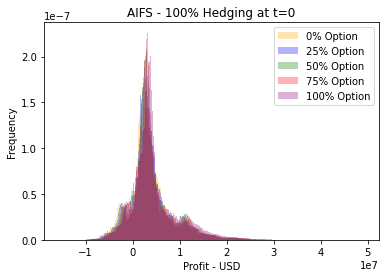

In [ ]:
# Plotting the values at risk 
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['100%_Hedge_100%_Option'], bins,density=True, color = 'orange', alpha=0.3, label = '0% Option')
pyplot.hist(profit['100%_Hedge_75%_Option'], bins,density=True, color = 'blue', alpha=0.3, label = '25% Option')
pyplot.hist(profit['100%_Hedge_50%_Option'], bins,density=True, color = 'green', alpha=0.3, label = '50% Option')
pyplot.hist(profit['100%_Hedge_25%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '75% Option')
pyplot.hist(profit['100%_Hedge_0%_Option'], bins,density=True, color = 'purple', alpha=0.3, label = '100% Option')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - 100% Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

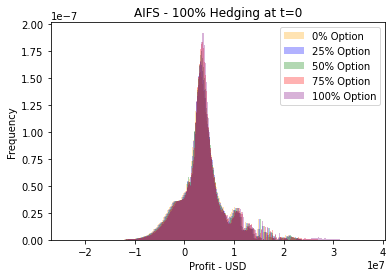

In [ ]:
# Plotting the values at risk 
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['50%_Hedge_100%_Option'], bins,density=True, color = 'orange', alpha=0.3, label = '0% Option')
pyplot.hist(profit['50%_Hedge_75%_Option'], bins,density=True, color = 'blue', alpha=0.3, label = '25% Option')
pyplot.hist(profit['50%_Hedge_50%_Option'], bins,density=True, color = 'green', alpha=0.3, label = '50% Option')
pyplot.hist(profit['50%_Hedge_25%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '75% Option')
pyplot.hist(profit['50%_Hedge_0%_Option'], bins,density=True, color = 'purple', alpha=0.3, label = '100% Option')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - 100% Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

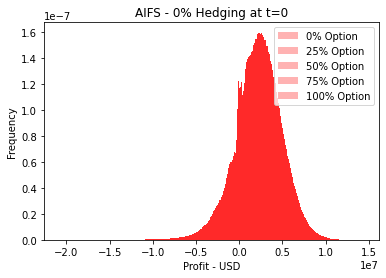

In [ ]:
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['0%_Hedge_100%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '0% Option')
pyplot.hist(profit['0%_Hedge_75%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '25% Option')
pyplot.hist(profit['0%_Hedge_50%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '50% Option')
pyplot.hist(profit['0%_Hedge_25%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '75% Option')
pyplot.hist(profit['0%_Hedge_0%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '100% Option')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - 0% Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

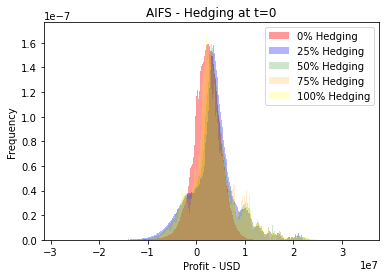

In [ ]:
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['0%_Hedge_100%_Option'], bins,density=True, color = 'red', alpha=0.4, label = '0% Hedging')
pyplot.hist(profit['25%_Hedge_100%_Option'], bins,density=True, color = 'blue', alpha=0.3, label = '25% Hedging')
pyplot.hist(profit['50%_Hedge_100%_Option'], bins,density=True, color = 'green', alpha=0.2, label = '50% Hedging')
pyplot.hist(profit['75%_Hedge_100%_Option'], bins,density=True, color = 'orange', alpha=0.2, label = '75% Hedging')
pyplot.hist(profit['100%_Hedge_100%_Option'], bins,density=True, color = 'yellow', alpha=0.2, label = '100% Hedging')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

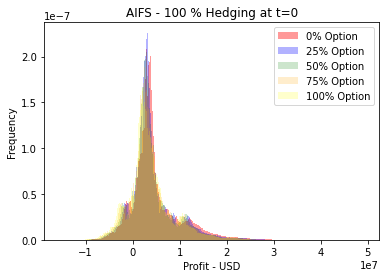

In [ ]:
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['100%_Hedge_0%_Option'], bins,density=True, color = 'red', alpha=0.4, label = '0% Option')
pyplot.hist(profit['100%_Hedge_25%_Option'], bins,density=True, color = 'blue', alpha=0.3, label = '25% Option')
pyplot.hist(profit['100%_Hedge_50%_Option'], bins,density=True, color = 'green', alpha=0.2, label = '50% Option')
pyplot.hist(profit['100%_Hedge_75%_Option'], bins,density=True, color = 'orange', alpha=0.2, label = '75% Option')
pyplot.hist(profit['100%_Hedge_100%_Option'], bins,density=True, color = 'yellow', alpha=0.2, label = '100% Option')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - 100 % Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

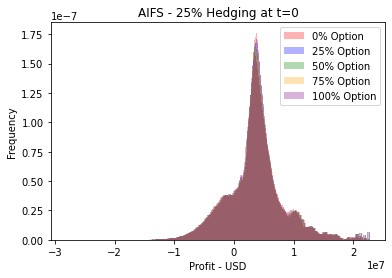

In [ ]:
bins = 300

#pyplot.hist(exposure_distribution_100hedge, 100,density=True, color = 'orange', alpha=0.3, label = '100% Hedge')
pyplot.hist(profit['25%_Hedge_0%_Option'], bins,density=True, color = 'red', alpha=0.3, label = '0% Option')
pyplot.hist(profit['25%_Hedge_25%_Option'], bins,density=True, color = 'blue', alpha=0.3, label = '25% Option')
pyplot.hist(profit['25%_Hedge_50%_Option'], bins,density=True, color = 'green', alpha=0.3, label = '50% Option')
pyplot.hist(profit['25%_Hedge_75%_Option'], bins,density=True, color = 'orange', alpha=0.3, label = '75% Option')
pyplot.hist(profit['25%_Hedge_100%_Option'], bins,density=True, color = 'purple', alpha=0.3, label = '100% Option')



plt.xlabel("Profit - USD")
plt.ylabel("Frequency")
plt.title("AIFS - 25% Hedging at t=0")
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
print(profit['0%_Hedge_0%_Option'].mean())
print(profit['0%_Hedge_25%_Option'].mean())
print(profit['0%_Hedge_50%_Option'].mean())
print(profit['0%_Hedge_75%_Option'].mean())
print(profit['0%_Hedge_100%_Option'].mean())

print(profit['25%_Hedge_0%_Option'].mean())
print(profit['25%_Hedge_25%_Option'].mean())
print(profit['25%_Hedge_50%_Option'].mean())
print(profit['25%_Hedge_75%_Option'].mean())
print(profit['25%_Hedge_100%_Option'].mean())


print(profit['50%_Hedge_0%_Option'].mean())
print(profit['50%_Hedge_25%_Option'].mean())
print(profit['50%_Hedge_50%_Option'].mean())
print(profit['50%_Hedge_75%_Option'].mean())
print(profit['50%_Hedge_100%_Option'].mean())

print(profit['75%_Hedge_0%_Option'].mean())
print(profit['75%_Hedge_25%_Option'].mean())
print(profit['75%_Hedge_50%_Option'].mean())
print(profit['75%_Hedge_75%_Option'].mean())
print(profit['75%_Hedge_100%_Option'].mean())

print(profit['100%_Hedge_0%_Option'].mean())
print(profit['100%_Hedge_25%_Option'].mean())
print(profit['100%_Hedge_50%_Option'].mean())
print(profit['100%_Hedge_75%_Option'].mean())
print(profit['100%_Hedge_100%_Option'].mean())

2191641.432701915
2191641.432701915
2191641.432701915
2191641.432701915
2191641.432701915
3745995.6790003725
3693841.1825862485
3641686.686172132
3589532.1897580135
3537377.693343892
4023009.4724513767
3874301.1917938697
3758441.5823542327
3654132.5895259907
3549823.5966977556
4210504.489452719
4036375.109777087
3875734.0060109897
3718732.9892939697
3562269.5000516134
4685448.152737416
4222950.392806584
3994555.098125857
3783333.3890619553
3574715.403405475


# Probability Analysis

In [ ]:
ecdf0_0 =  ECDF(profit['0%_Hedge_0%_Option'])
ecdf0_25 =  ECDF(profit['0%_Hedge_25%_Option'])
ecdf0_50 =  ECDF(profit['0%_Hedge_50%_Option'])
ecdf0_75 =  ECDF(profit['0%_Hedge_75%_Option'])
ecdf0_100 =  ECDF(profit['0%_Hedge_100%_Option'])

ecdf25_0 =  ECDF(profit['25%_Hedge_0%_Option'])
ecdf25_25 =  ECDF(profit['25%_Hedge_25%_Option'])
ecdf25_50 =  ECDF(profit['25%_Hedge_50%_Option'])
ecdf25_75 =  ECDF(profit['25%_Hedge_75%_Option'])
ecdf25_100 =  ECDF(profit['25%_Hedge_100%_Option'])

ecdf50_0 =  ECDF(profit['50%_Hedge_0%_Option'])
ecdf50_25 =  ECDF(profit['50%_Hedge_25%_Option'])
ecdf50_50 =  ECDF(profit['50%_Hedge_50%_Option'])
ecdf50_75 =  ECDF(profit['50%_Hedge_75%_Option'])
ecdf50_100 =  ECDF(profit['50%_Hedge_100%_Option'])

ecdf75_0 =  ECDF(profit['75%_Hedge_0%_Option'])
ecdf75_25 =  ECDF(profit['75%_Hedge_25%_Option'])
ecdf75_50 =  ECDF(profit['75%_Hedge_50%_Option'])
ecdf75_75 =  ECDF(profit['75%_Hedge_75%_Option'])
ecdf75_100 =  ECDF(profit['75%_Hedge_100%_Option'])

ecdf100_0 =  ECDF(profit['100%_Hedge_0%_Option'])
ecdf100_25 =  ECDF(profit['100%_Hedge_25%_Option'])
ecdf100_50 =  ECDF(profit['100%_Hedge_50%_Option'])
ecdf100_75 =  ECDF(profit['100%_Hedge_75%_Option'])
ecdf100_100 =  ECDF(profit['100%_Hedge_100%_Option'])

'''
pyplot.plot(ecdf.x, ecdf.y)
pyplot.title('Cumulative Distribution Funciton')
pyplot.xlabel('Expense_Exposure')
pyplot.ylabel('Cumulative Probability')
pyplot.show()
'''

"\npyplot.plot(ecdf.x, ecdf.y)\npyplot.title('Cumulative Distribution Funciton')\npyplot.xlabel('Expense_Exposure')\npyplot.ylabel('Cumulative Probability')\npyplot.show()\n"

In [ ]:
print('0 Hedging, 0 Option P(x<0): %.3f' % ecdf0_0(0))
print('0 Hedging, 25 Option P(x<0): %.3f' % ecdf0_25(0))
print('0 Hedging, 50 Option P(x<0): %.3f' % ecdf0_50(0))
print('0 Hedging, 75 Option P(x<0): %.3f' % ecdf0_75(0))
print('0 Hedging, 100 Option P(x<0): %.3f' % ecdf0_100(0))

print('25 Hedging, 0 Option P(x<0): %.3f' % ecdf25_0(0))
print('25 Hedging, 25 Option P(x<0): %.3f' % ecdf25_25(0))
print('25 Hedging, 50 Option P(x<0): %.3f' % ecdf25_50(0))
print('25 Hedging, 75 Option P(x<0): %.3f' % ecdf25_75(0))
print('25 Hedging, 100 Option P(x<0): %.3f' % ecdf25_100(0))

print('50 Hedging, 0 Option P(x<0): %.3f' % ecdf50_0(0))
print('50 Hedging, 25 Option P(x<0): %.3f' % ecdf50_25(0))
print('50 Hedging, 50 Option P(x<0): %.3f' % ecdf50_50(0))
print('50 Hedging, 75 Option P(x<0): %.3f' % ecdf50_75(0))
print('50 Hedging, 100 Option P(x<0): %.3f' % ecdf50_100(0))

print('75 Hedging, 0 Option P(x<0): %.3f' % ecdf75_0(0))
print('75 Hedging, 25 Option P(x<0): %.3f' % ecdf75_25(0))
print('75 Hedging, 50 Option P(x<0): %.3f' % ecdf75_50(0))
print('75 Hedging, 75 Option P(x<0): %.3f' % ecdf75_75(0))
print('75 Hedging, 100 Option P(x<0): %.3f' % ecdf75_100(0))

print('100 Hedging, 0 Option P(x<0): %.3f' % ecdf100_0(0))
print('100 Hedging, 25 Option P(x<0): %.3f' % ecdf100_25(0))
print('100 Hedging, 50 Option P(x<0): %.3f' % ecdf100_50(0))
print('100 Hedging, 75 Option P(x<0): %.3f' % ecdf100_75(0))
print('100 Hedging, 100 Option P(x<0): %.3f' % ecdf100_100(0))


0 Hedging, 0 Option P(x<0): 0.186
0 Hedging, 25 Option P(x<0): 0.186
0 Hedging, 50 Option P(x<0): 0.186
0 Hedging, 75 Option P(x<0): 0.186
0 Hedging, 100 Option P(x<0): 0.186
25 Hedging, 0 Option P(x<0): 0.183
25 Hedging, 25 Option P(x<0): 0.187
25 Hedging, 50 Option P(x<0): 0.190
25 Hedging, 75 Option P(x<0): 0.194
25 Hedging, 100 Option P(x<0): 0.198
50 Hedging, 0 Option P(x<0): 0.157
50 Hedging, 25 Option P(x<0): 0.163
50 Hedging, 50 Option P(x<0): 0.171
50 Hedging, 75 Option P(x<0): 0.179
50 Hedging, 100 Option P(x<0): 0.188
75 Hedging, 0 Option P(x<0): 0.135
75 Hedging, 25 Option P(x<0): 0.142
75 Hedging, 50 Option P(x<0): 0.151
75 Hedging, 75 Option P(x<0): 0.163
75 Hedging, 100 Option P(x<0): 0.177
100 Hedging, 0 Option P(x<0): 0.118
100 Hedging, 25 Option P(x<0): 0.125
100 Hedging, 50 Option P(x<0): 0.135
100 Hedging, 75 Option P(x<0): 0.149
100 Hedging, 100 Option P(x<0): 0.169


In [ ]:
def plot_ecdf(data,title = "CDF Plot 0% Options", xlabel = 'Profit', ylabel = 'Percentage'):
    
    """ 
    Function to plot ecdf taking a column of data as input.
    """
    xaxis = np.sort(data)
    yaxis = np.arange(1, len(data)+1)/len(data)
    plt.plot(xaxis,yaxis,linestyle='none',marker='.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.margins(0.02)

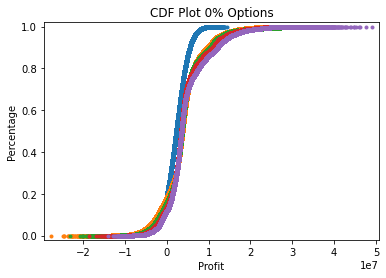

In [ ]:
plot_ecdf(profit['0%_Hedge_0%_Option'])
plot_ecdf(profit['25%_Hedge_0%_Option'])
plot_ecdf(profit['50%_Hedge_0%_Option'])
plot_ecdf(profit['75%_Hedge_0%_Option'])
plot_ecdf(profit['100%_Hedge_0%_Option'])